# Some testing

Load data

In [1]:
import pandas as pd

# Load df from csv
raw_data = pd.read_csv("data/train.csv")

selected_cols = ["property_max_guests", 
                 "property_bathrooms", 
                 "property_bedrooms", 
                 "property_beds", 
                 "host_response_rate", 
                 "host_nr_listings",
                 "host_nr_listings_total",
                 "booking_price_covers",
                 "booking_min_nights",
                 "booking_availability_30",
                 "booking_availability_60",
                 "booking_availability_90",
                 "booking_availability_365",
                 "reviews_rating",
                 "reviews_acc",
                 "reviews_cleanliness",
                 "reviews_checkin",
                 "reviews_communication",
                 "reviews_location",
                 "reviews_value",
                 "reviews_per_month"]

# Filter df to only include a selection of cols
X = raw_data[selected_cols]
y = raw_data["target"]

## Cleaning here
(VERY ROUGH)

In [2]:
# Impute median for missing (check warning)
X.iloc[:, :].fillna(X.iloc[:, :].median(), inplace = True)

# 0 NA left
print(X.isnull().sum())

# Shape still the same
X.shape

property_max_guests         0
property_bathrooms          0
property_bedrooms           0
property_beds               0
host_response_rate          0
host_nr_listings            0
host_nr_listings_total      0
booking_price_covers        0
booking_min_nights          0
booking_availability_30     0
booking_availability_60     0
booking_availability_90     0
booking_availability_365    0
reviews_rating              0
reviews_acc                 0
reviews_cleanliness         0
reviews_checkin             0
reviews_communication       0
reviews_location            0
reviews_value               0
reviews_per_month           0
dtype: int64


C:\Users\amarm\AppData\Local\Temp\ipykernel_6296\3717280874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.iloc[:, :].fillna(X.iloc[:, :].median(), inplace = True)


(6495, 21)

### Descriptives


In [3]:
# Simple descriptive stats
y.describe()
X.describe()

,property_max_guests,property_bathrooms,property_bedrooms,property_beds,host_response_rate,host_nr_listings,host_nr_listings_total,booking_price_covers,booking_min_nights,booking_availability_30,...,booking_availability_90,booking_availability_365,reviews_rating,reviews_acc,reviews_cleanliness,reviews_checkin,reviews_communication,reviews_location,reviews_value,reviews_per_month
count,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,...,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000,6495.000000
mean,2.999076,1.141032,1.205697,1.741493,93.847267,6.095150,6.095150,1.432333,3.531948,9.410931,...,38.404311,171.840339,91.971209,9.583680,9.381216,9.693303,9.702694,9.189222,9.192918,1.517219
std,1.778460,0.455912,0.750032,1.338870,17.451859,36.863287,36.863287,0.965370,16.569408,10.539133,...,33.139699,141.683736,8.001921,0.804234,1.026752,0.735088,0.729182,0.801182,0.832367,1.809195
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.010000
25%,2.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,16.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.420000
50%,2.000000,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,1.000000,2.000000,5.000000,...,37.000000,153.000000,93.000000,10.000000,10.000000,10.000000,10.000000,9.000000,9.000000,0.910000
75%,4.000000,1.000000,1.000000,2.000000,100.000000,2.000000,2.000000,2.000000,3.000000,17.000000,...,69.000000,321.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.790000
max,16.000000,8.000000,8.000000,16.000000,100.000000,591.000000,591.000000,16.000000,1000.000000,30.000000,...,90.000000,365.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,19.900000


<Axes: ylabel='Density'>

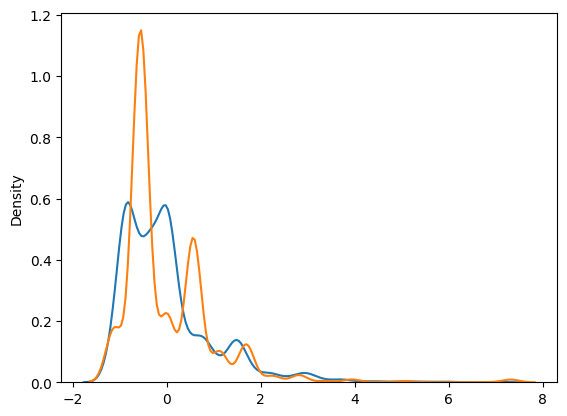

In [5]:
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize and standardize predictors
nrm_X = preprocessing.normalize(X)
std_X1 = preprocessing.scale(X)
std_X = preprocessing.scale(nrm_X)

# Note: orange = scaled, blue = scaled+normalized
sns.kdeplot(std_X[:, 0])
sns.kdeplot(std_X1[:, 0])

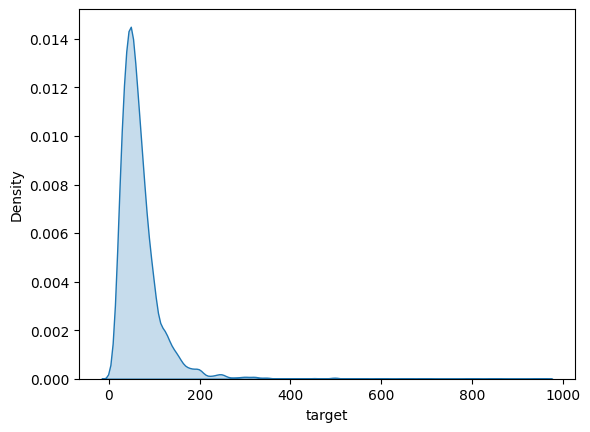

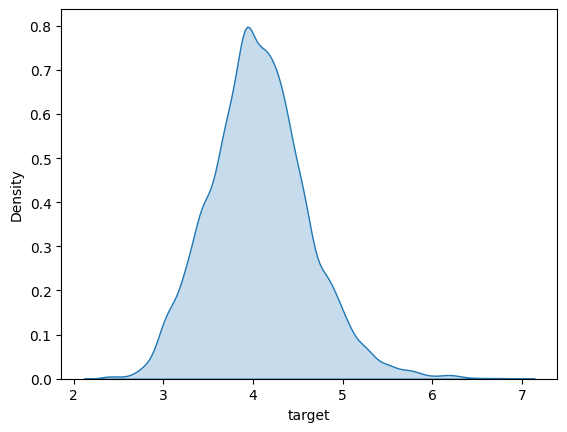

In [19]:
import numpy as np

# Plot target distribution
sns.kdeplot(y, fill = True)
plt.show()

# Log transform
y_log = np.log1p(y)
sns.kdeplot(y_log, fill = True)
plt.show()


### Visualizing relations

In [20]:
# ...

## XGBoost

First split train & test (ignore test.csv for now)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(std_X, y_log, test_size=0.2)

Fit XGBoost model

In [22]:
import xgboost as xgb

model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Predict test set and evaluate model

In [23]:
preds = model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, preds))

print(rmse)

0.338673480725442
